# Trabalho final **BI Master PUC Rio**

# **Detecção de vazamento e diagnóstico inicial de falha em turbinas de geração a gás**

Davi Oliveira Francisco  Matrícula: 231101072  
Professor: Leonardo M.

 No contexto de FPSOs (Floating Production Storage and Offloading), as GTGs (Gas Turbine Generators) são essenciais para garantir o fornecimento contínuo de energia elétrica, viabilizando as operações de extração, processamento e armazenamento de óleo em ambiente offshore. Devido à criticidade desses equipamentos, é imprescindível manter alta disponibilidade e confiabilidade, reduzindo ao máximo o tempo de inatividade não planejado. Um dos principais desafios de manutenção preditiva nessas turbinas é o monitoramento do aumento do consumo de óleo lubrificante, que pode indicar falhas incipientes, como vazamentos ou desgaste de componentes internos. O presente trabalho propõe o desenvolvimento de features e modelos de aprendizado de máquina para detecção automática de padrões anômalos no consumo de óleo das GTGs, possibilitando intervenções proativas e contribuindo para a integridade operacional, redução de custos e mitigação de riscos associados a falhas graves nesses sistemas críticos.
 
 **Este notebook** apresenta o desenvolvimento de um sistema para **detecção de vazamentos** e **diagnóstico inicial de falhas** em **turbinas de geração a gás**, utilizando **dados simulados** de sensores instalados em plataformas de petróleo.

 O objetivo é **identificar automaticamente eventos anômalos**, como **vazamentos**, a partir da análise de **séries temporais** dos sensores, empregando técnicas de **ciência de dados** e **aprendizado de máquina**.

 Ao longo do notebook, são abordadas as seguintes etapas principais:
 - **Preparação dos dados**
 - **Extração de features**
 - **Construção e avaliação de modelos**
 - **Implementação de mecanismos de alarme** para suporte à tomada de decisão.


# Importando bibliotecas necessárias para o notebook principal

In [156]:
import warnings
import re
import os
import json
from importlib import reload
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lol_lib
from lol_lib.utils import *
from lol_lib.utils import get_test_assets_from_config

reload(lol_lib.utils)

# Pandas display options
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_row", 20)
pd.options.mode.chained_assignment = None

# Numpy and warnings options
np.seterr(all='ignore')
warnings.filterwarnings('ignore')

# Reunindo dados para treinar o modelo

Os dados deste trabalho simulam uma base de sensores de turbinas geradoras a gás. Ela possui diversas turbinas de geração a gás que operam continuamente em plataformas de petróleo e estão sujeitas a vazamentos. A base inicial possui 3 colunas: status (0: máquina parada e 2: máquina operando), level (em %, referente ao nível do tanque) e asset (equipamento em questão).
 
 Lista das bases utilizadas:
 
 1. all_data: todos os dados das turbinas, considerando a operação normal dos ativos, podendo haver curtos intervalos de vazamento.
2. all_data_features: todos os dados da primeira base já tratados e com features geradas.
3. Dados de teste: dados mais recentes das máquinas, nos quais se sabe que houve vazamento, para teste do modelo e da estrutura de alarmes criada.

Carregando e visualizando a base de dados inicial disponível.

In [9]:
all_data = pd.read_csv("output_files/all_data_bimtcc.csv")
all_data['timestamp'] = pd.to_datetime(all_data['timestamp'])
all_data = all_data.set_index('timestamp')
all_data.head()

,status,level,asset
timestamp,,,
2024-08-12 22:00:00,0.0,74.0,GTG_0
2024-08-12 23:00:00,0.0,74.0,GTG_0
2024-08-13 00:00:00,0.0,74.0,GTG_0
2024-08-13 01:00:00,0.0,74.0,GTG_0
2024-08-13 02:00:00,0.0,74.0,GTG_0


# EDA  
Listando todos os ativos disponíveis em all_data para exploração inicial

In [3]:
all_data.asset.unique()

array(['GTG_0', 'GTG_1', 'GTG_2', 'GTG_3', 'GTG_4', 'GTG_5', 'GTG_6',
       'GTG_7', 'GTG_8', 'GTG_9', 'GTG_10', 'GTG_11', 'GTG_12', 'GTG_13',
       'GTG_14', 'GTG_15', 'GTG_16', 'GTG_17', 'GTG_18', 'GTG_19',
       'GTG_20', 'GTG_21', 'GTG_22'], dtype=object)

Explorando a quantidade de registros que temos por asset para entender o universo de dados disponível

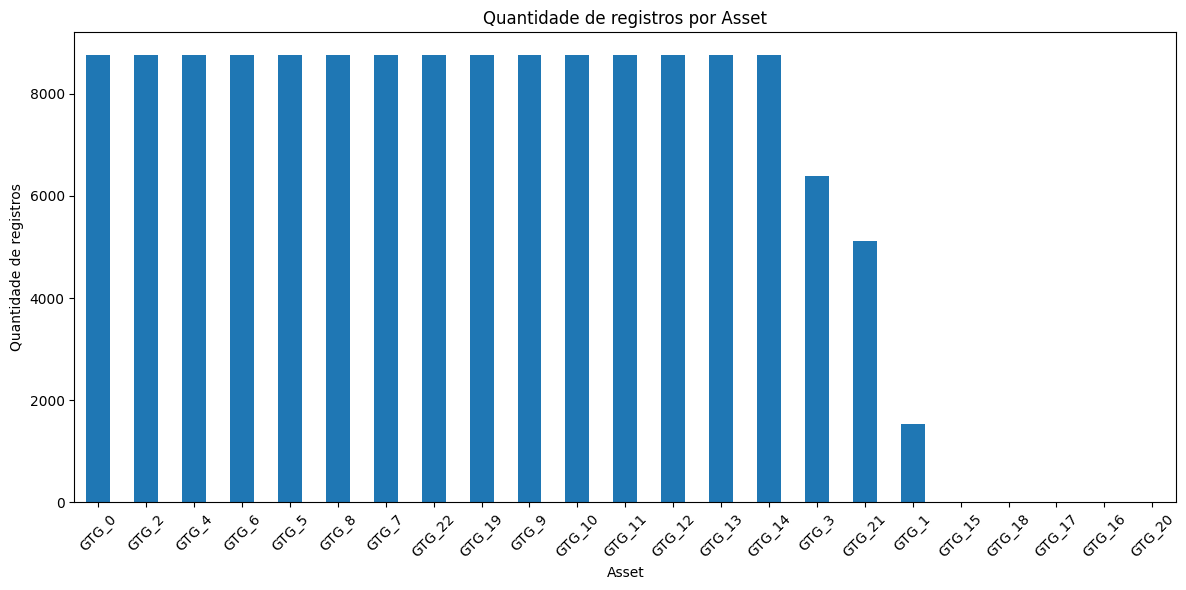

In [24]:
asset_counts = all_data['asset'].value_counts()
plt.figure(figsize=(12,6))
asset_counts.plot(kind='bar')
plt.xlabel('Asset')
plt.ylabel('Quantidade de registros')
plt.title('Quantidade de registros por Asset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observamos que alguns estão com poucos registros (em alguns casos apenas 1). **Não afeta a análise final.**

Continuando a exploração da base podemos primeiramente plotar os dados de um dado equipamento para entender o comportamento.

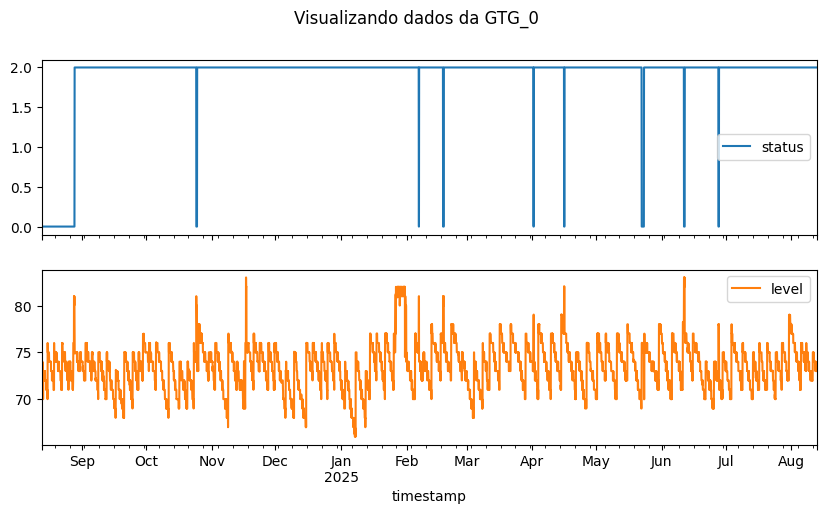

In [28]:
all_data[all_data.asset == "GTG_0"].plot(subplots=True, figsize=(10, 5), title="Visualizando dados da GTG_0")
plt.show()

## **Ponto chave da EDA**

Observamos nos dados de nível que nos momentos de operação das máquinas temos um **consumo de óleo natural da operação**. Esse consumo deve ser compensado com **preenchimentos ao longo da operação** e isso resulta no sinal que parece um dente de serra que vemos no plot.

O problema que estamos procurando se manifesta quando encontramos alterações na taxa de vazamento, evidenciado por aumento na frequência de preenchimento de óleo.

# **Feature engineering**

Com o objetivo de detectar vazamentos nesses equipamentos é necessário criar features para que possamos identificar aumento ou qualquer alteração no consumo de óleo. Nesse contexto, foram desenvolvidas algumas funções específicas para calcular features que podem ajudar na detecção dessas alterações.

Algumas funções chave da etapa de *features engineering* são:

- remove_transition_periods
- create_features_refined
- detect_changepoint
- regressao_intervalos_level


Primeiro vamos processar todas as turbinas disponíveis criando as features mencionadas e depois visualizar e discutir os resultados obtidos.

In [ ]:
all_data_features = pd.DataFrame()
i = 0
for gtg in tqdm(all_data.asset.unique(), desc=f"Processando GTG:"):

    df_temp = all_data[all_data.asset == gtg]

    df_temp = remove_transition_periods(df_temp, hours_buffer=12)

    # Filtra onde a coluna de status é igual a 2 e mantém os valores de level nos índices válidos
    mask = df_temp["status"] == 2
    df_temp = df_temp.loc[mask]

    df_temp['level'] = pd.to_numeric(df_temp['level'], errors='coerce')

    try:
        df_temp['daily_consumption'], df_temp['auto_id'], df_temp['auto_group_values'] = create_features_refined(df_temp, level_col="level")

        df_temp['changepoint_id'], df_temp['changepoint_v'] = detect_changepoint(df_temp, 'auto_id', 'daily_consumption', penalty=3, changepoint_model='rbf')
        
        df_temp["composed_risk"] = (df_temp["changepoint_v"] + df_temp["auto_group_values"])/2

        regressao_intervalos_level(df_temp, col_level="level", diff_reabastecimento=None, n_intervalos_iniciais=6)

    except Exception as e:
        print(f"Erro ao criar features para o GTG '{gtg}': {e}")
        continue

    all_data_features = pd.concat([all_data_features, df_temp], axis=0)

    i += 1

    # break


Processando GTG::  65%|██████▌   | 15/23 [01:31<00:54,  6.78s/it]

Erro ao criar features para o GTG 'GTG_15': Standard deviation is zero
Erro ao criar features para o GTG 'GTG_16': Standard deviation is zero
Erro ao criar features para o GTG 'GTG_17': Standard deviation is zero
Erro ao criar features para o GTG 'GTG_18': Standard deviation is zero


Processando GTG::  87%|████████▋ | 20/23 [01:36<00:08,  2.85s/it]

Erro ao criar features para o GTG 'GTG_20': Standard deviation is zero


Processando GTG:: 100%|██████████| 23/23 [01:46<00:00,  4.63s/it]


Visualizando os resultados apenas para uma turbina como exemplo.

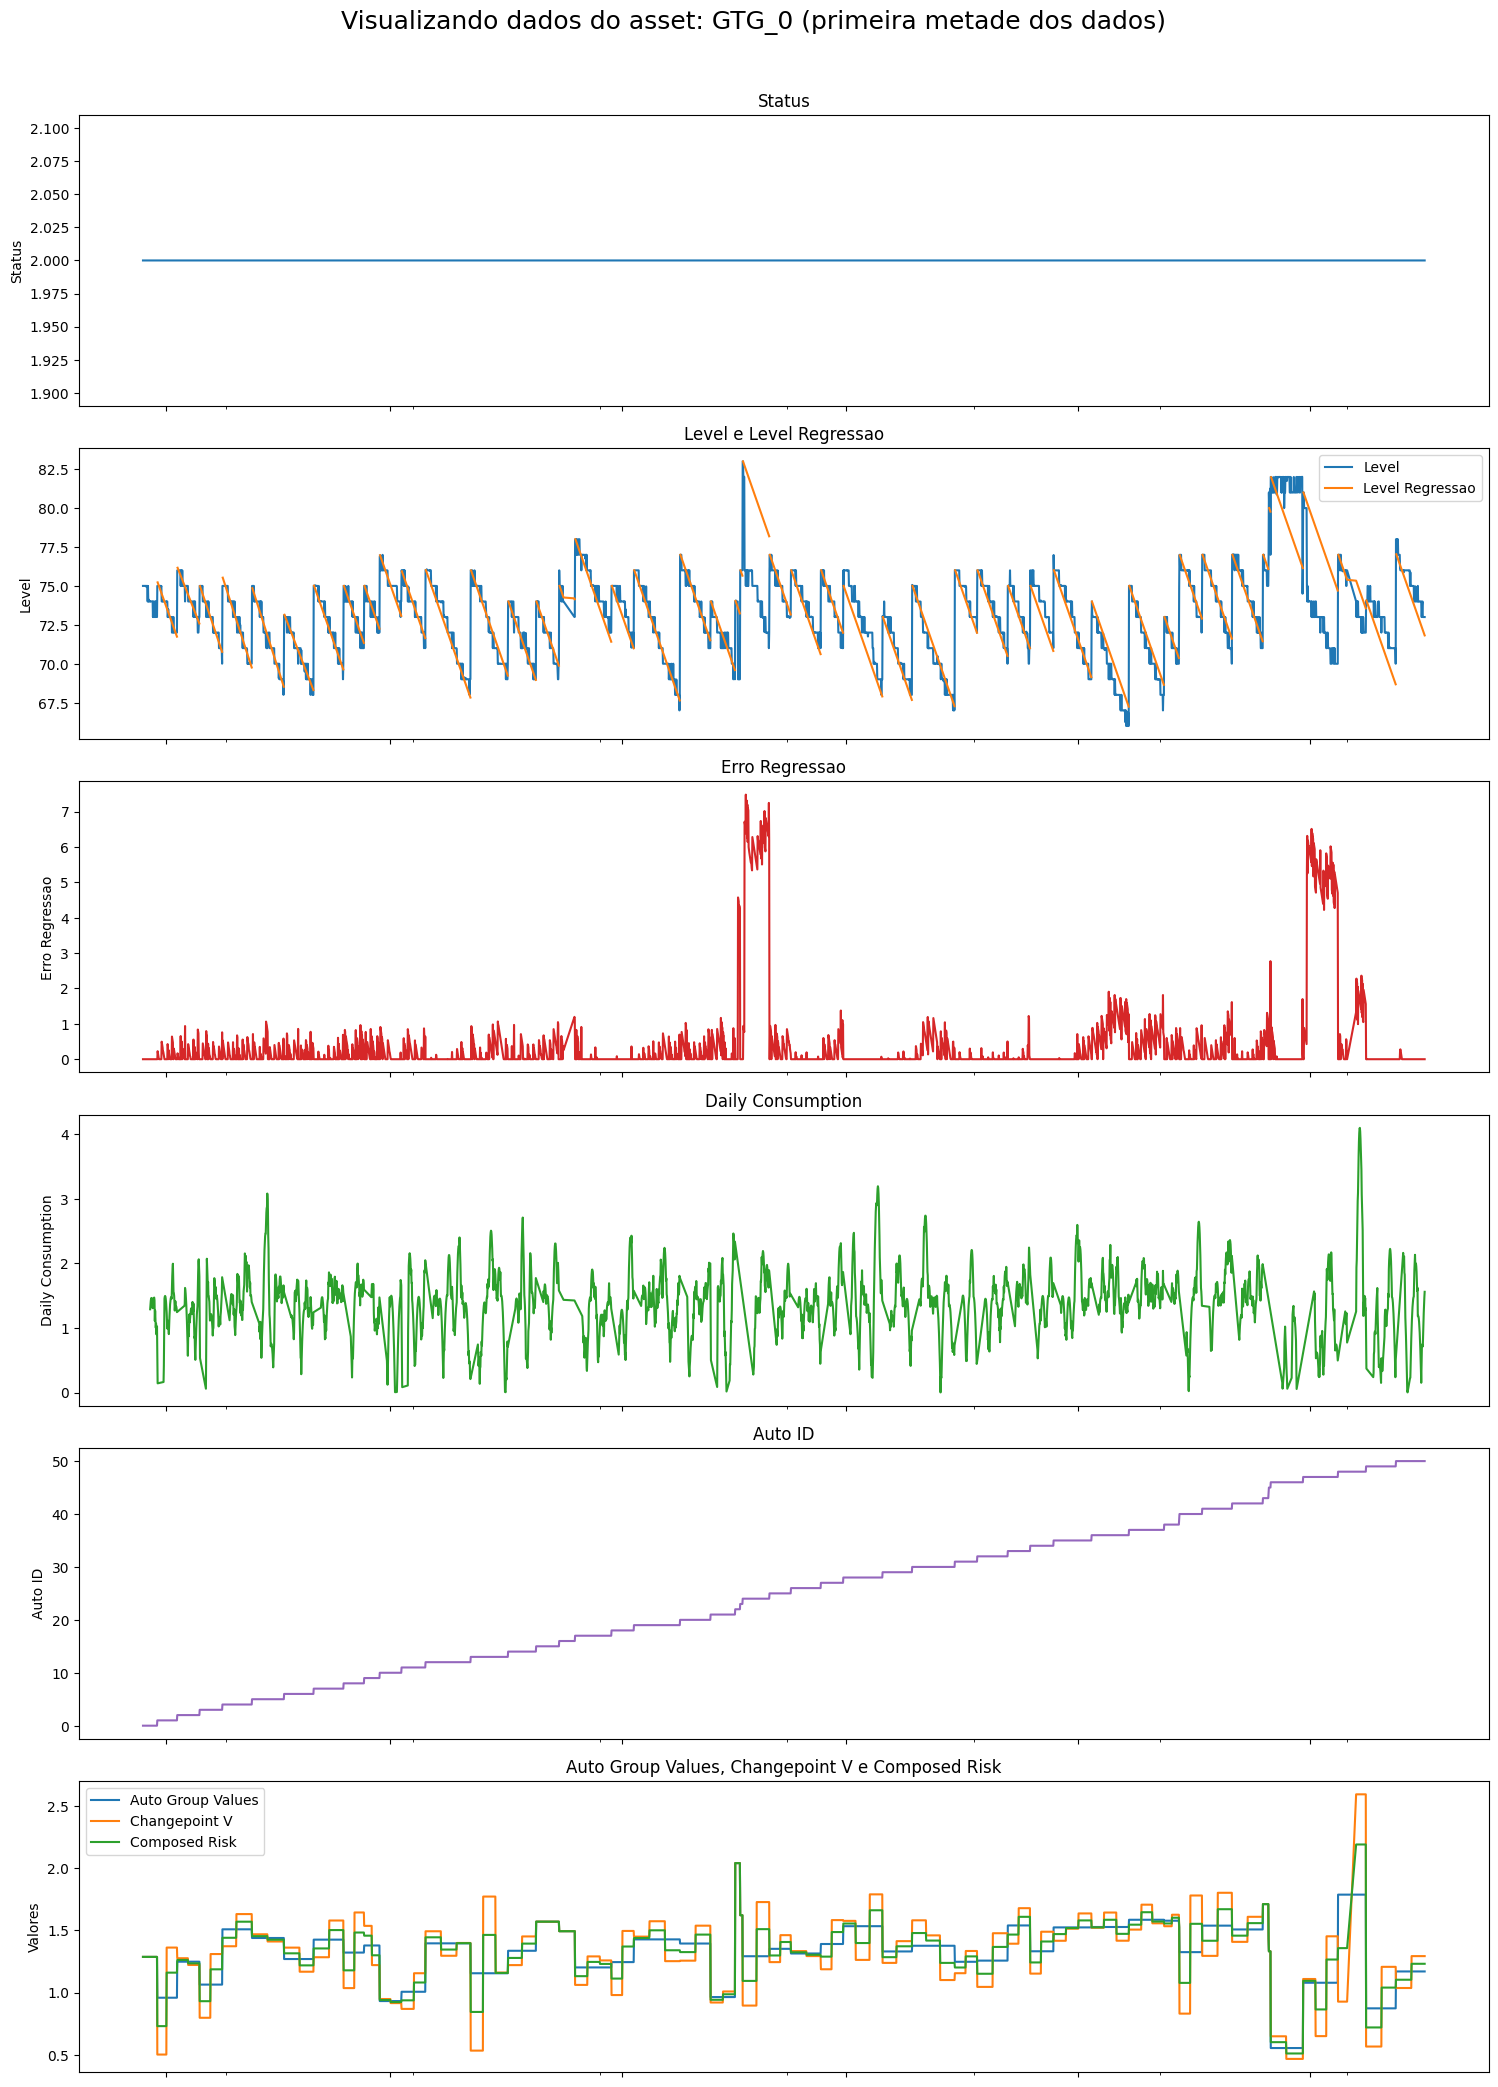

In [ ]:
# Seleciona o primeiro asset disponível em all_data_features para exemplificar
primeiro_asset = all_data_features['asset'].iloc[0]
plot_data = all_data_features[all_data_features['asset'] == primeiro_asset]

# Pega só metade dos dados filtrados
n_half = len(plot_data) // 2
plot_data = plot_data.iloc[:n_half]

fig, axs = plt.subplots(8, 1, figsize=(15, 28), sharex=True)
fig.suptitle(f"Visualizando dados do asset: {primeiro_asset} (primeira metade dos dados)", fontsize=18)

# 1. Status
if "status" in plot_data.columns:
    plot_data["status"].plot(ax=axs[0], title="Status", color="tab:blue")
    axs[0].set_ylabel("Status")
else:
    axs[0].set_visible(False)

# 2. Level e Level Regressao no mesmo plot
has_level = "level" in plot_data.columns
has_level_reg = "level_regressao" in plot_data.columns
if has_level or has_level_reg:
    if has_level:
        plot_data["level"].plot(ax=axs[1], label="Level", color="tab:blue")
    if has_level_reg:
        plot_data["level_regressao"].plot(ax=axs[1], label="Level Regressao", color="tab:orange")
    axs[1].set_title("Level e Level Regressao")
    axs[1].set_ylabel("Level")
    axs[1].legend()
else:
    axs[1].set_visible(False)

# 3. Erro Regressao
if "level_erro_regressao" in plot_data.columns:
    plot_data["level_erro_regressao"].plot(ax=axs[2], title="Erro Regressao", color="tab:red")
    axs[2].set_ylabel("Erro Regressao")
else:
    axs[2].set_visible(False)

# 4. Daily Consumption
if "daily_consumption" in plot_data.columns:
    plot_data["daily_consumption"].plot(ax=axs[3], title="Daily Consumption", color="tab:green")
    axs[3].set_ylabel("Daily Consumption")
else:
    axs[3].set_visible(False)

# 5. Auto ID
if "auto_id" in plot_data.columns:
    plot_data["auto_id"].plot(ax=axs[4], title="Auto ID", color="tab:purple")
    axs[4].set_ylabel("Auto ID")
else:
    axs[4].set_visible(False)

# 6. auto_group_values, changepoint_v e composed_risk no mesmo plot
has_auto_group = "auto_group_values" in plot_data.columns
has_changepoint_v = "changepoint_v" in plot_data.columns
has_composed_risk = "composed_risk" in plot_data.columns
if has_auto_group or has_changepoint_v or has_composed_risk:
    if has_auto_group:
        plot_data["auto_group_values"].plot(ax=axs[5], label="Auto Group Values", color="tab:blue")
    if has_changepoint_v:
        plot_data["changepoint_v"].plot(ax=axs[5], label="Changepoint V", color="tab:orange")
    if has_composed_risk:
        plot_data["composed_risk"].plot(ax=axs[5], label="Composed Risk", color="tab:green")
    axs[5].set_title("Auto Group Values, Changepoint V e Composed Risk")
    axs[5].set_ylabel("Valores")
    axs[5].legend()
else:
    axs[5].set_visible(False)

axs[6].set_visible(False)

axs[7].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


  **Geração de Features para Detecção de Vazamentos**
  
  Na etapa anterior, realizamos a engenharia de features essenciais para análise do consumo de óleo e detecção de vazamentos. O principal indicador criado foi o **daily_consumption**, que representa o consumo diário estimado a partir das variações do nível de óleo, já filtrando ruídos e reabastecimentos. Essa feature de daily_consumption é fundamental para o modelo e ajuda na interpretabilidade das features geradas.
  
  Para segmentar o comportamento do consumo, utilizamos dois métodos de agrupamento:
  
  1. **Auto Group Values**: O primeiro método identifica saltos abruptos no nível de óleo (tipicamente associados a reabastecimentos) e divide a série temporal em grupos automáticos entre esses eventos. Para cada grupo, é calculada a média do consumo diário, resultando na feature **auto_group_values**. Essa abordagem captura tendências de consumo em períodos mais longos, entre reabastecimentos.
  
  2. **Changepoint**: O segundo método aplica detecção de pontos de mudança (changepoints) dentro de cada grupo automático, utilizando a biblioteca ruptures. Isso permite identificar alterações mais sutis ou repentinas no padrão de consumo que podem ocorrer mesmo entre dois reabastecimentos, onde o risco de vazamento pode aumentar rapidamente.
  
  Por fim, foi criada a feature **composed_risk**, que combina a média do consumo dos grupos automáticos (**auto_group_values**) com as variações detectadas pelos changepoints. O objetivo é obter um indicador de risco mais robusto: enquanto o auto_group_values reflete variações de longo prazo, o changepoint enfatiza mudanças agudas que podem sinalizar o início ou agravamento de um vazamento entre reabastecimentos. O composed_risk será utilizado como principal métrica para detecção de vazamentos ao longo do tempo.
  
  **Features de Regressão Linear por Intervalos**
  
  Além das features acima, também foi implementada a geração de features baseadas em regressão linear por intervalos, por meio da função `regressao_intervalos_level`. Essa função segmenta a série temporal de nível de óleo em intervalos delimitados por eventos de reabastecimento (ou saltos abruptos) e, para cada intervalo, ajusta uma regressão linear. O coeficiente angular (slope) dessa regressão representa a inclinação média do consumo naquele período, enquanto o erro da regressão indica o quanto o comportamento real se desvia de uma tendência linear simples.
  
  Essas features de regressão têm o objetivo de replicar, de forma quantitativa, a análise visual **frequentemente realizada** por engenheiros, que comparam as inclinações dos trechos entre reabastecimentos para identificar padrões anômalos de consumo. Assim, tanto o valor da regressão quanto o erro associado podem ser utilizados (ou ao menos testados) em modelos de detecção, enriquecendo o conjunto de variáveis e permitindo capturar mudanças de comportamento que não seriam evidentes apenas pelas médias dos grupos ou pelos changepoints.


Salvando dados para testes mais rápidos.

In [63]:
all_data_features.to_csv("output_files/all_data_features_bimtcc.csv", index=True)
# all_data_features = pd.read_csv("output_files/all_data_features_bimtcc.csv")

Explorando dados gerados e refinando outliers com base em conhecimento técnico dos equipamentos para minimizar efeitos negativos nos modelos.

In [71]:
all_data_features = all_data_features[
    (all_data_features['level'] >= 58) &
    (all_data_features['level'] <= 90) &
    (all_data_features["daily_consumption"] <= 2.5) &
    (all_data_features["auto_group_values"] >= 0) &
    (all_data_features["auto_group_values"] <= 2) &
    (all_data_features["changepoint_v"] <= 2.5) &
    (all_data_features["composed_risk"] <= 2.5) &
    (all_data_features["level_regressao"] >= 59)
]

Visualizando dados tratados.

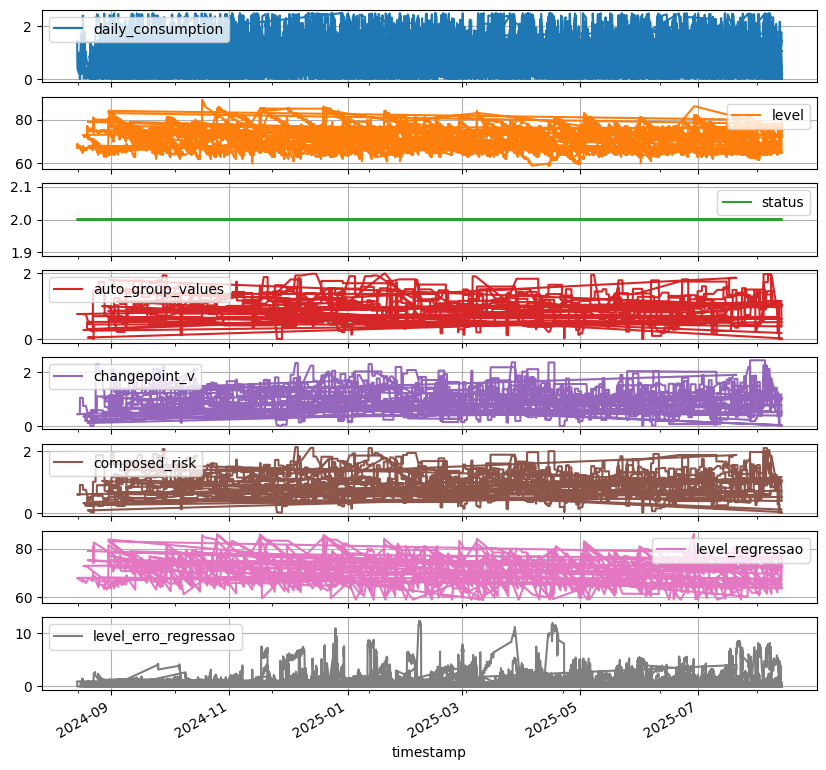

In [144]:
all_data_features[["daily_consumption", 
                   "level", 
                   "status", 
                   "auto_group_values", 
                   "changepoint_v", 
                   "composed_risk", 
                   "level_regressao", 
                   "level_erro_regressao"]].plot(subplots=True, figsize=(10, 10), grid=True)
plt.show()

Ao analisar os dados após todos os tratamentos aplicados, observa-se a presença de alguns pontos considerados **anômalos**. Esses pontos são fundamentais para a **robustez** e a capacidade de **generalização** do modelo, especialmente porque o **dataset** é composto por registros de diversos **equipamentos similares**. A **diversidade de ativos** representados amplia o espectro de **variações operacionais** capturadas, tornando o modelo mais apto a identificar **padrões anômalos** em diferentes contextos reais. Além disso, a existência de possíveis eventos de **falha rápida** ao longo do conjunto de dados enriquece o processo de **treinamento**, permitindo que o modelo aprenda a distinguir entre **variações normais** e comportamentos realmente **críticos**. Dessa forma, o uso de um **dataset heterogêneo**, com múltiplos equipamentos e eventuais falhas, contribui significativamente para o desenvolvimento de um sistema de **detecção de anomalias** mais **sensível**, **confiável** e aplicável a cenários práticos.

# Modelo

Na etapa de desenvolvimento do modelo vamos assumir, como vimos anteriormente, que os dados fornecidos, em parte, **apresentam a operação sem anomalias.** Nesse sentido conseguimos treinar um modelo de **detecção de anomalia**, com os dados fornecidos, baseado em algumas features que já calculamos. 

Nesta parte do trabalho, serão testadas algumas abordagens e suas variações de modelos aplicados a dois casos conhecidos de vazamento. **Como informação adicional**, foi construída uma análise inicial automatizada da falha indicando qual consumo anômalo foi detectado, por quanto tempo durou, e qual era o comportamento esperado.

A seguir serão detalhadas as diferentes combinações de modelos e features. A busca pelo melhor modelo, considerando que **não temos um alto volume de labels** para realizar o treinamento de modelos supervisionados, será feita por amostragem.

## [MODELO 1] IsolationForest

Aplicando o IsolationForest com o conjunto de features ["level", "daily_consumption", "composed_risk"] trouxe resultados excepcionais para a detecção de vazamento. O primeiro caso tem exatamente esse período marcado pelo modelo como problema claro de vazamento.

O mesmo comportamento é obtido no segundo teste, marcando exatamente o momento de mudança de consumo de óleo no equipamento. 

In [162]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

# Selecionar as colunas para normalização
features = ["level", "daily_consumption", "composed_risk"]
plot_cols = ["level", "daily_consumption", "composed_risk"]

# Normalizar os dados
scaler = MinMaxScaler()
all_data_ge_norm = all_data_features.copy()
all_data_ge_norm[features] = scaler.fit_transform(all_data_features[features])

# Treinar Isolation Forest com baixa contaminação
iso_forest = IsolationForest(contamination=0.001, random_state=42)
iso_forest.fit(all_data_ge_norm[features])


,n_estimators,100
,max_samples,'auto'
,contamination,0.001
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


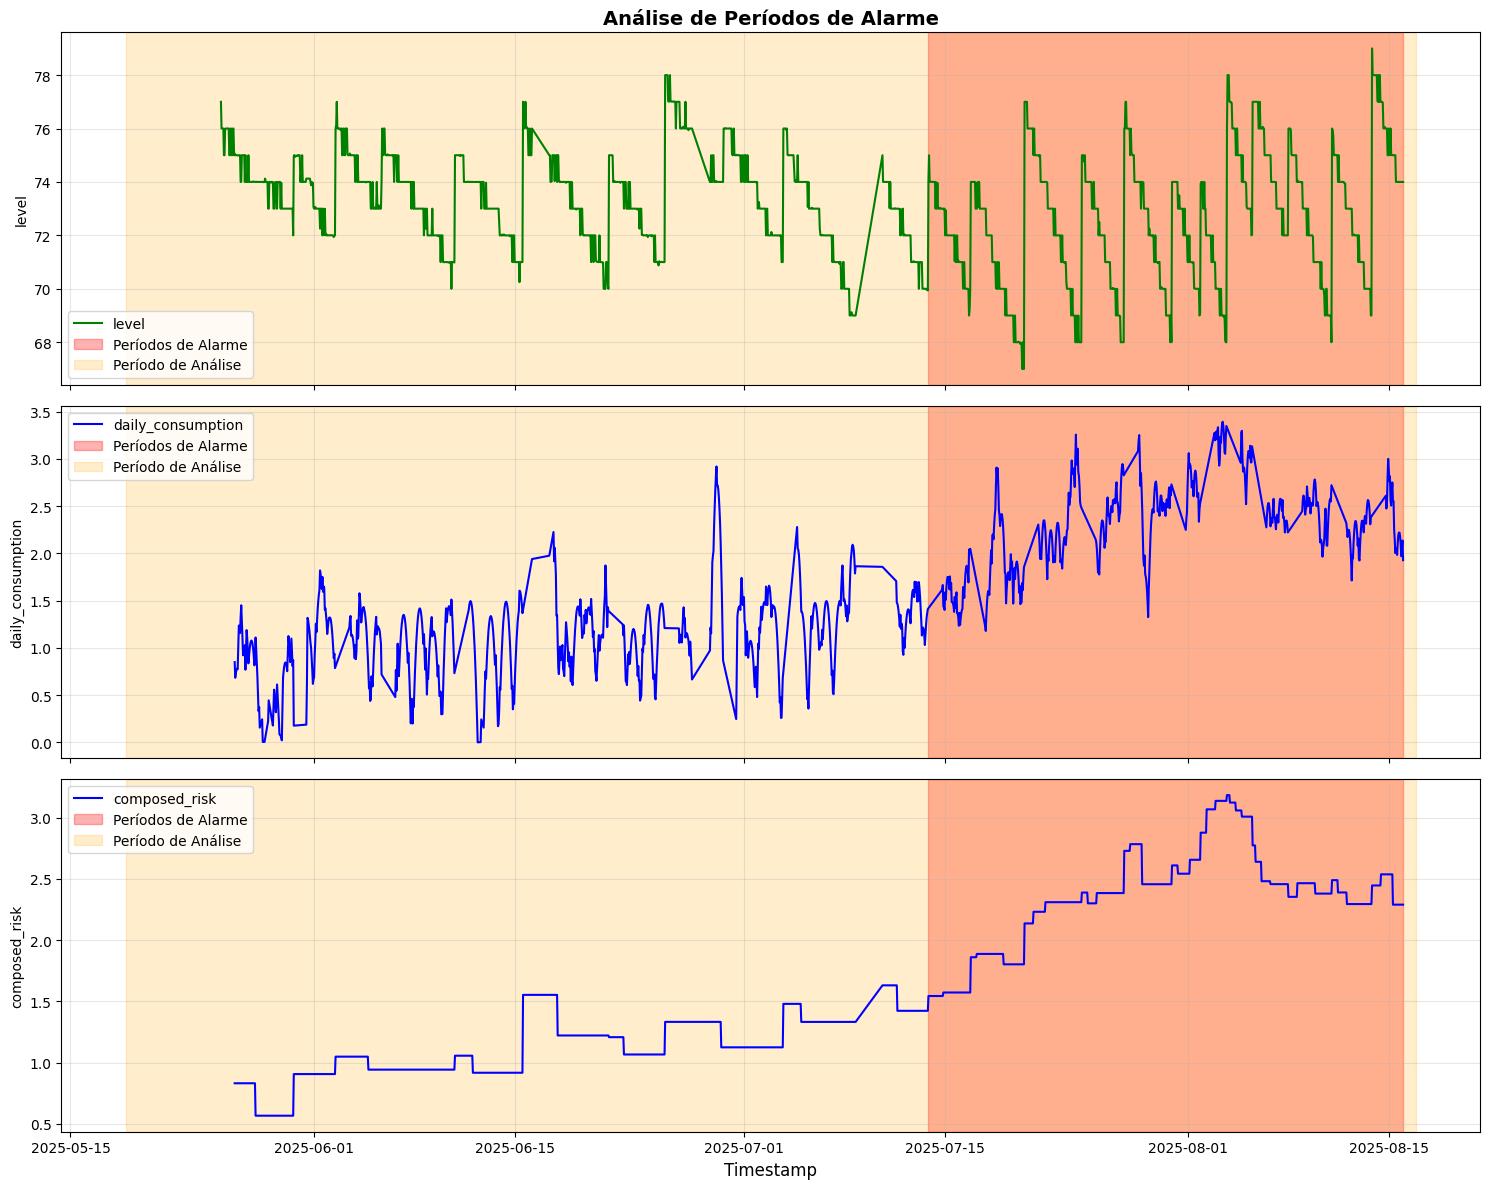


📊 Resumo de Alarmes:
   • Total de períodos detectados: 1
   • Consumo de 2.4%/dia detectado, quando o esperado era 1.1%/dia. Início 2025-07-13 21:00 e fim 2025-08-16 00:00 (Duração: 795.0h)
Tratando problema de nível


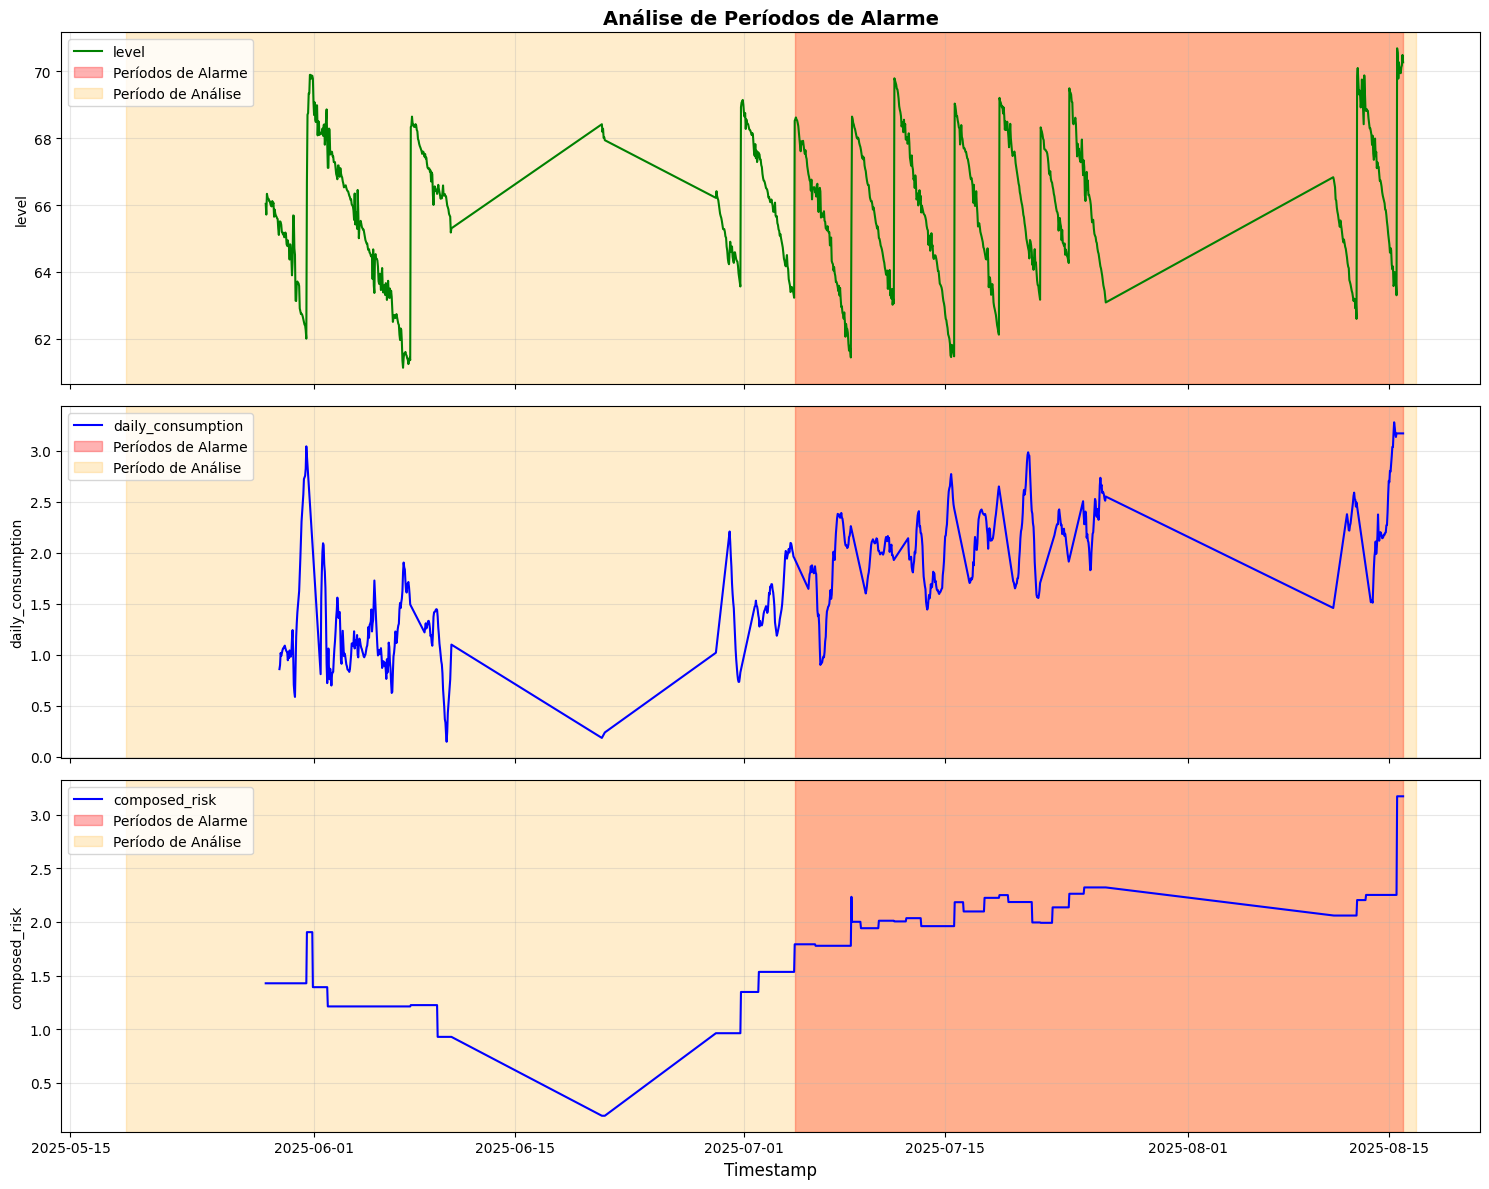


📊 Resumo de Alarmes:
   • Total de períodos detectados: 1
   • Consumo de 2.1%/dia detectado, quando o esperado era 1.3%/dia. Início 2025-07-04 13:00 e fim 2025-08-16 00:00 (Duração: 1019.0h)


In [163]:
test_gtgs = get_test_assets_from_config()

for gtg in test_gtgs:
    try:
        plot_asset_anomaly_periods(gtg, 
                                   if_model=iso_forest, 
                                   days_back=90, 
                                   features=features,
                                   plot_cols=plot_cols,
                                   )
    except Exception as e:
        print(f"Erro ao processar: {e}")

## [MODELO 2] IsolationForest com outro conjunto de features

Nesse segundo exemplo a ideia foi testar a teoria de que o erro do sinal de nível com relação a regressão poderia ajudar o modelo na detecção do problema. Olhando para o resultado final podemos concluir que essa feature extra não teve o impacto esperado no modelo, visto que apenas subdividiu o intervalo do alarme em períodos menores. 

Essa subdivisão não é ideal em um caso de aplicação onde o engenheiro responsável pelo monitoramento do ativo já deve ter outras atividades e alarmes para monitorar.

Os resultados do segundo equipamento reforçam a queda de performance quando comparado com o primeiro conjunto de features, visto que apenas um período curto foi detectado.

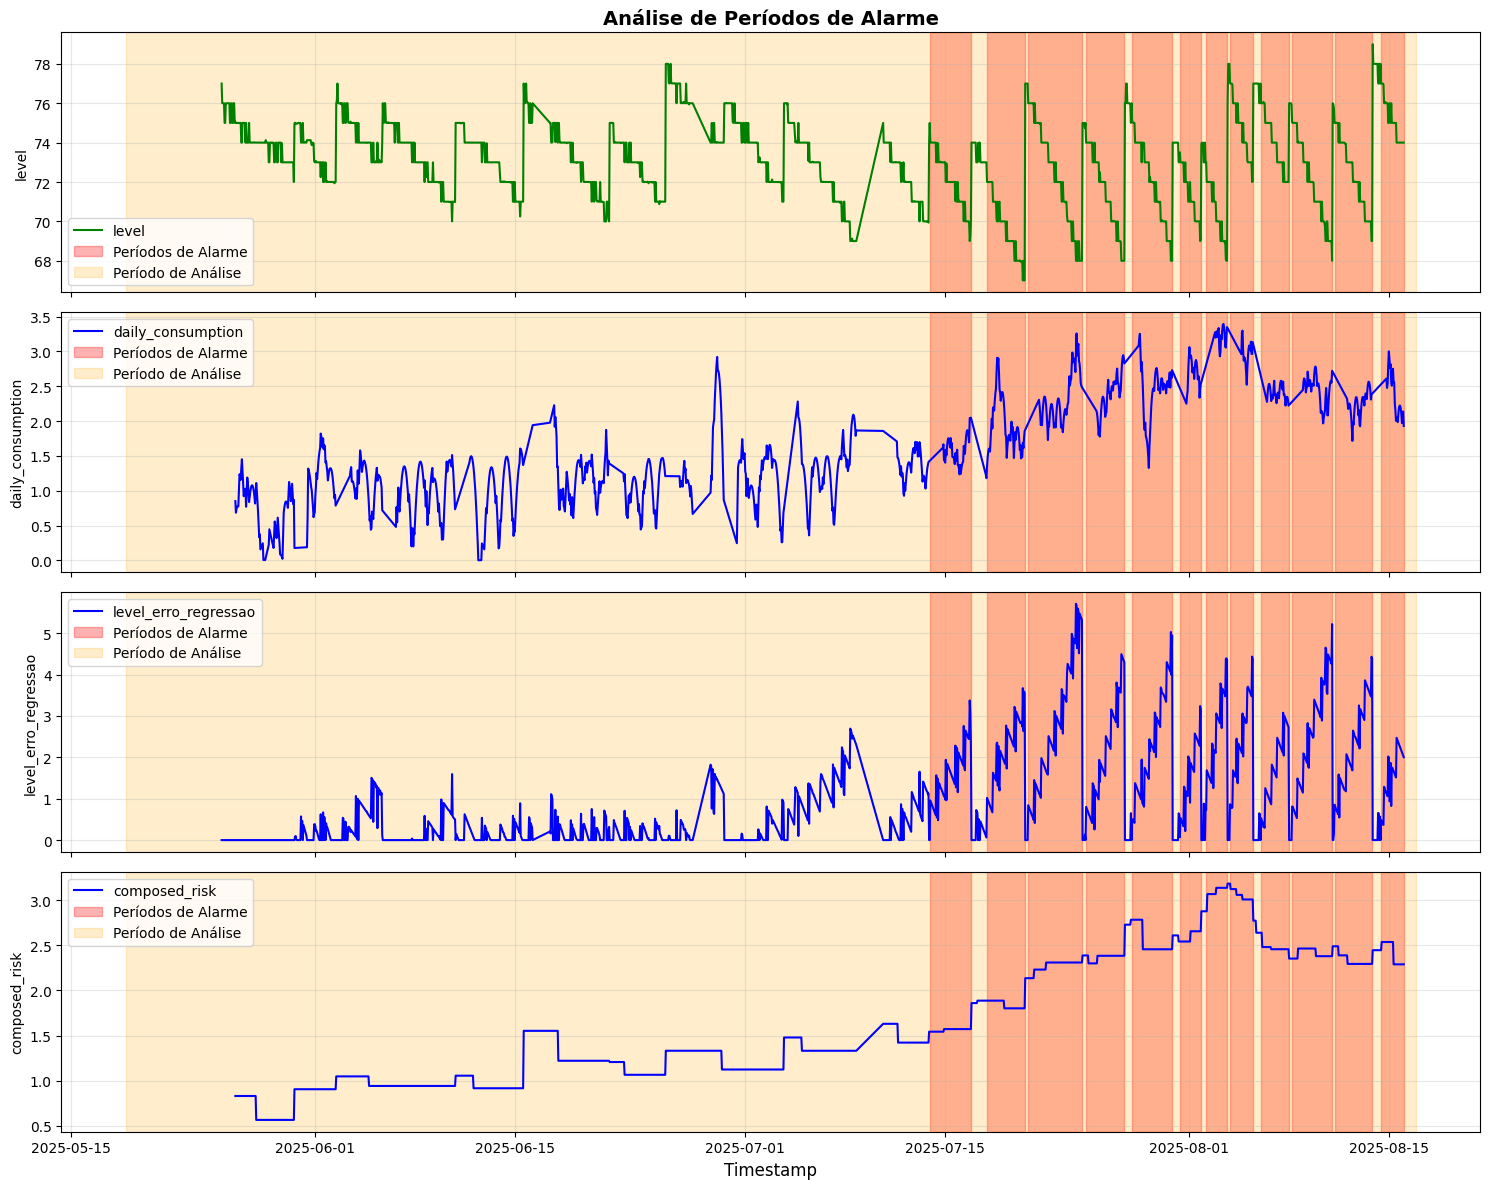


📊 Resumo de Alarmes:
   • Total de períodos detectados: 12
   • Consumo de 1.6%/dia detectado, quando o esperado era 1.2%/dia. Início 2025-07-13 23:00 e fim 2025-07-16 19:00 (Duração: 68.0h)
   • Consumo de 1.8%/dia detectado, quando o esperado era 1.2%/dia. Início 2025-07-17 22:00 e fim 2025-07-20 13:00 (Duração: 63.0h)
   • Consumo de 2.3%/dia detectado, quando o esperado era 1.2%/dia. Início 2025-07-20 19:00 e fim 2025-07-24 13:00 (Duração: 90.0h)
   • Consumo de 2.4%/dia detectado, quando o esperado era 1.2%/dia. Início 2025-07-24 20:00 e fim 2025-07-27 12:00 (Duração: 64.0h)
   • Consumo de 2.5%/dia detectado, quando o esperado era 1.2%/dia. Início 2025-07-28 01:00 e fim 2025-07-30 20:00 (Duração: 67.0h)
   • Consumo de 2.6%/dia detectado, quando o esperado era 1.2%/dia. Início 2025-07-31 10:00 e fim 2025-08-01 20:00 (Duração: 34.0h)
   • Consumo de 3.1%/dia detectado, quando o esperado era 1.2%/dia. Início 2025-08-02 04:00 e fim 2025-08-03 16:00 (Duração: 36.0h)
   • Consumo de 

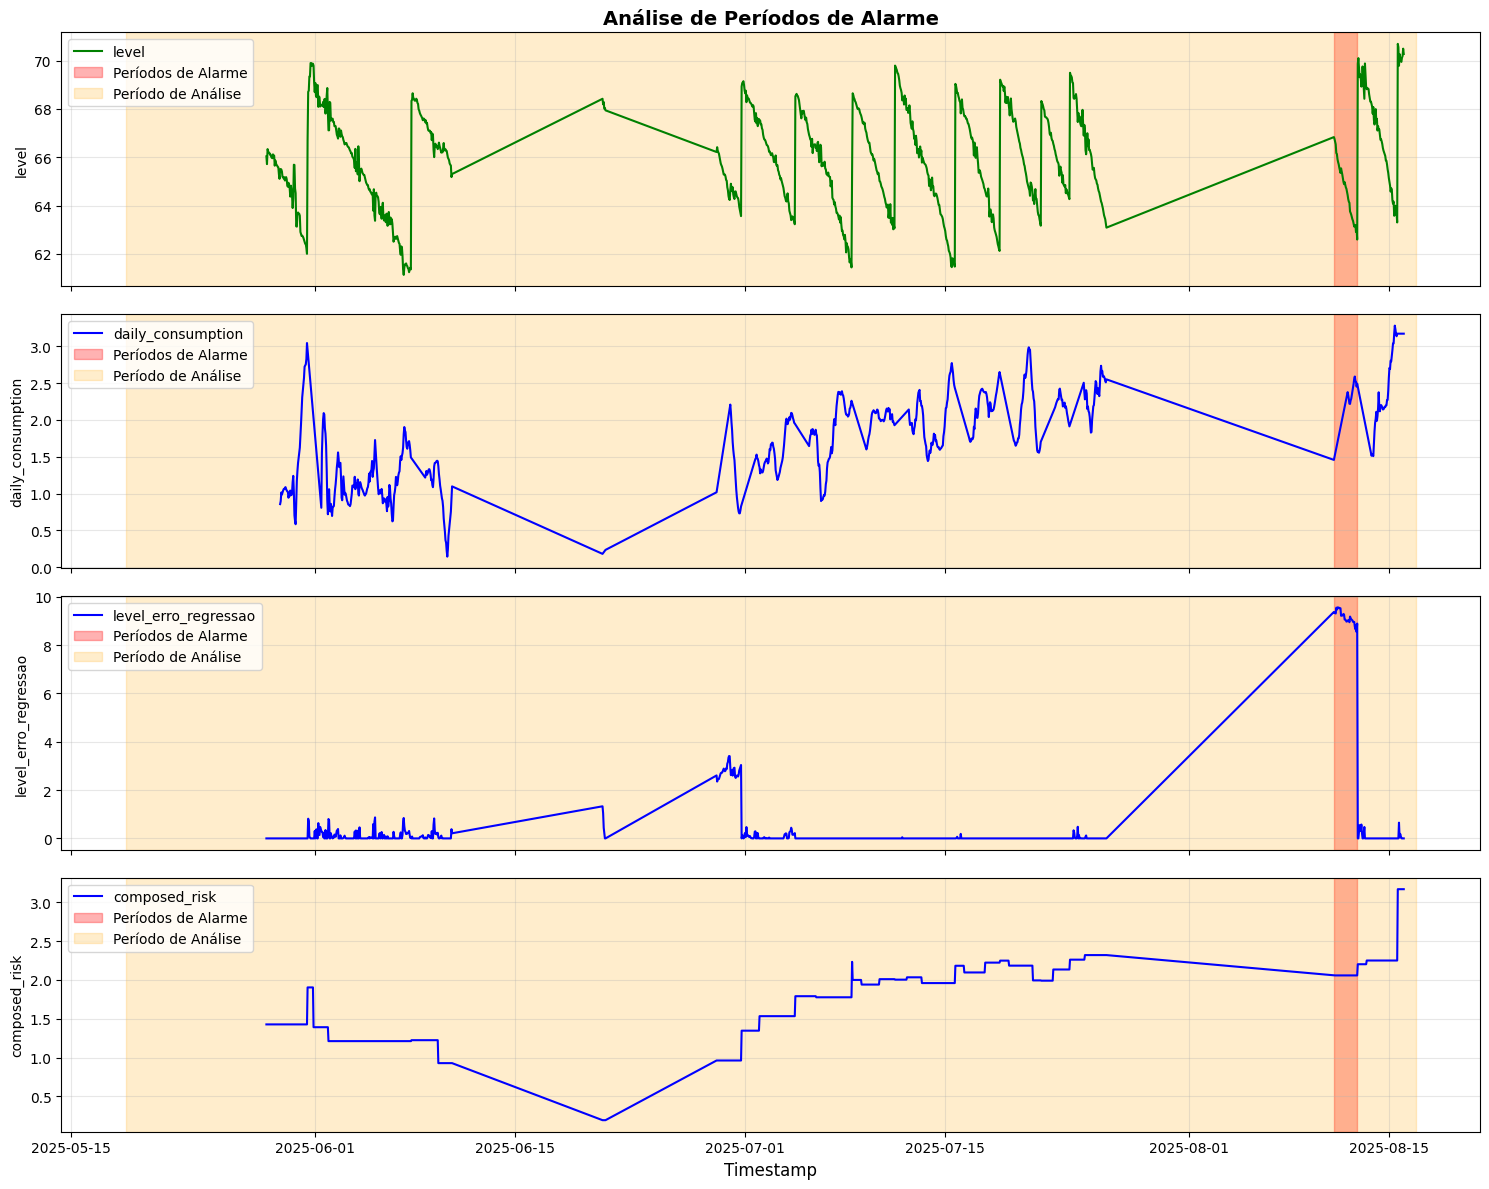


📊 Resumo de Alarmes:
   • Total de períodos detectados: 1
   • Consumo de 2.1%/dia detectado, quando o esperado era 1.7%/dia. Início 2025-08-11 03:00 e fim 2025-08-12 18:00 (Duração: 39.0h)


In [146]:
# Selecionar as colunas para normalização
features = ["level", "daily_consumption", "level_erro_regressao", "composed_risk"]
plot_cols = ["level", "daily_consumption", "level_erro_regressao", "composed_risk"]

# Normalizar os dados
scaler = MinMaxScaler()
all_data_ge_norm = all_data_features.copy()
all_data_ge_norm[features] = scaler.fit_transform(all_data_features[features])

# Treinar Isolation Forest com baixa contaminação
iso_forest = IsolationForest(contamination=0.001, random_state=42)
iso_forest.fit(all_data_ge_norm[features])

test_gtgs = get_test_assets_from_config()

for gtg in test_gtgs:
    try:
        plot_asset_anomaly_periods(gtg, 
                                   if_model=iso_forest, 
                                   days_back=90, 
                                   features=features, 
                                   level_col="level",
                                   plot_cols=plot_cols,
                                   )
    except Exception as e:
        print(f"Erro ao processar: {e}")

## [MODELO 3] OCSVM

O terceiro modelo, OCSVM, se mostra extremamente capaz de detectar as alterações de forma consistente nos equipamentos testados e pode ser considerado também como uma opção de modeloa a ser colocado em produção para evitar falhas inesperadas.

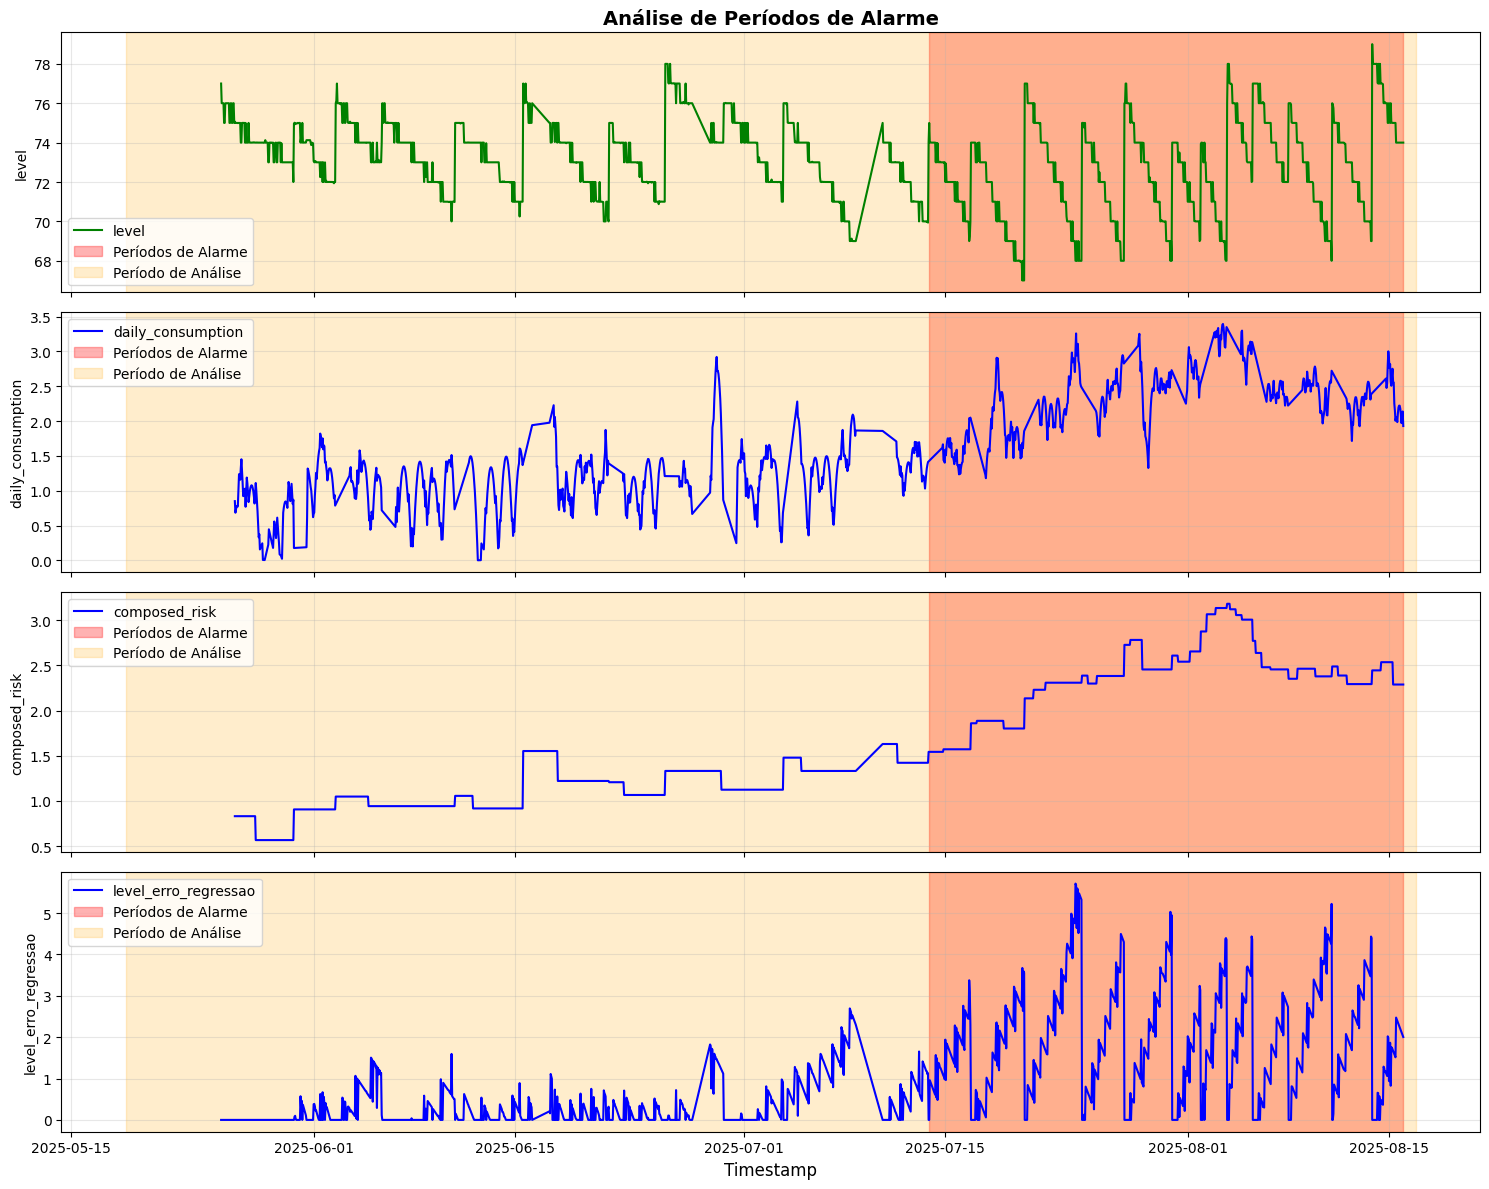


📊 Resumo de Alarmes:
   • Total de períodos detectados: 1
   • Consumo de 2.4%/dia detectado, quando o esperado era 1.1%/dia. Início 2025-07-13 21:00 e fim 2025-08-16 00:00 (Duração: 795.0h)
Tratando problema de nível


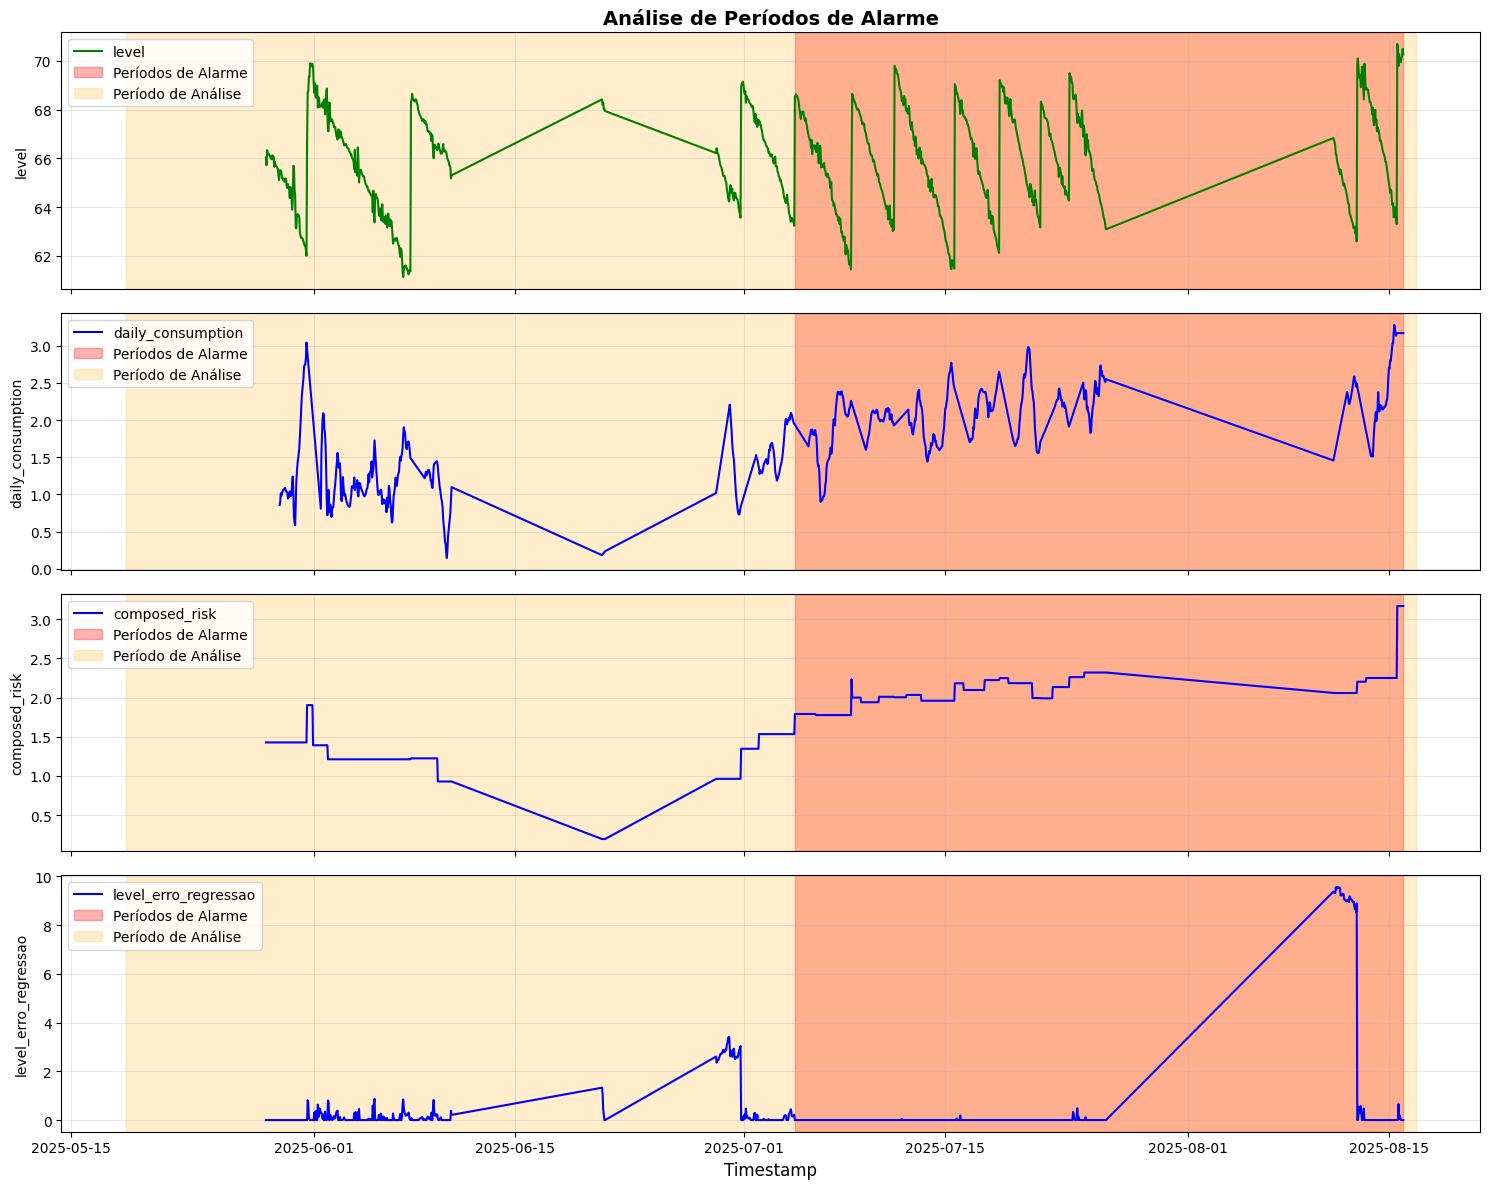


📊 Resumo de Alarmes:
   • Total de períodos detectados: 1
   • Consumo de 2.1%/dia detectado, quando o esperado era 1.3%/dia. Início 2025-07-04 13:00 e fim 2025-08-16 00:00 (Duração: 1019.0h)


In [161]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Features para testar
features = ["level", "daily_consumption", "composed_risk", "level_erro_regressao"]
plot_cols = features

# Normalizar dados
scaler = StandardScaler()
all_data_norm = all_data_features.copy().dropna()
all_data_norm[features] = scaler.fit_transform(all_data_features[features])

# Treinar OCSVM
ocsvm = OneClassSVM(gamma='auto', nu=0.001)  # nu similar ao contamination
ocsvm.fit(all_data_norm[features])

# Testar
for gtg in test_gtgs:
    plot_asset_anomaly_periods(gtg, 
                               if_model=ocsvm, 
                               features=features,
                               days_back=90,
                               plot_cols=plot_cols,
                               )

# Conclusões e trabalhos futuros

A análise de resultados mostra que a conbinação correta de features e modelo pode fornecer insights valiosos para a rotina de um engenheiro de confiabilidade. Os modelos 1 e 3 desenvolvidos demonstraram clara capacidade de geração de valor no contexto de manutenção preditiva em FPSOs e unidos ao sistema de alarmes construído em conjunto podem ajudar o engenheiro a se dedicar a outras atividades confiando o trabalho de detecção de vazamentos em turbinas para o sistema desenvolvido. 

Como trabalhos futuros seria interessante aplicar ao modelo em questão mais features para estudar o impacto na capacidade de detecção e outros modelos mais modernos e complexos (como AutoEncoders e redes MLP, por exemplo). Outro ponto extremamente interessante a ser explorados seria a implementação de diagnóstico usando LLMs e análises de outros atributos do equipamento como carga na turbina e outros fatores que podem afetar o consumo de óleo nesses equipamentos que podem resultar em falso positivos em produção.
